# Esame di Machine learning con applicazioni
### Davide Nicoli, matricola 980508
Nella seguente presentazione si farà un confronto tra due approcci di Machine Learning alla soluzione del problema di previsione degli inquinanti atmosferici posto nella competizione kaggle [Tabular Playground Series - July 2021](https://www.kaggle.com/competitions/tabular-playground-series-jul-2021/overview):
- [regressione lineare](#linear-regression);
- [reti neurali ricorrenti](#recurrent-neural-networks).

Visto il contesto del lavoro non si sono fatte analisi approfondite: ci si è limitati a fare un confronto tra metodi diversi e sondare alcune opzioni fornite da uno stesso approccio.
Nello specifico, la sezione sulla regressione lineare comparerà un modello regolarizzato con uno non regolarizzato, mentre la sezione sulle RNN mostrerà se ci sono apprezzabili differenze nel cambiare:
1. il numero di parametri ricorrenti nella rete;
2. la quantità fittata (dati puri contro dati normalizzati).

## Presentazione del dataset
Il dataset fornito raccoglie misure orarie di 3 variabili climatologiche (temperatura, umidità relativa, umidità assoluta), 5 variabili relative alla qualità dell'aria non ben specificate (indicate come "sensor_i", i da 1 a 5) e la concentrazione di 3 inquinanti atmosferici ($\mathrm{CO}$, $\mathrm{C_6H_6}$ e $\mathrm{NO_X}$), effettuate nel corso del 2010 dal 10 marzo al 1 gennaio 2011.

Nell'ambito della competizione Kaggle è richiesto di provvedere una stima delle concentrazioni dei suddetti inquinanti per il periodo dal 01-01-2011 al 04-04-2011 a partire dalla misura delle 8 features (dataset di submission).

### Scelte relative all'impiego dei dati
Per ragioni legate all'ambito del lavoro (e al mantenerlo di una ragionevole lunghezza) si è scelto di:
- lavorare su una singola configurazione di "folding" del dataset di trainig: sono stati utilizzati i primi 60 giorni per la validazione di modelli allenati sui rimanenti 236; tali numeri permettono di effettuare uno split di circa 20%-80% dei dati ed avere un multiplo di 5 giorni per la validazione (cosa che tornerà utile per le rnn). Non verrà quindi effettuata cross-validation sul dataset intero, anche perchè considerata la natura stocastica dei modelli basati su neural networks andrebbe trattata in maniera molto particolare;
- ignorare il dataset di submission, che non permette di avere un riscontro numerico delle performance dei modelli;
- tralasciare operazioni di data augmentation e features reduction:
    - data augmentation per introdurre features temporali come l'ora del giorno o il giorno della settimana (utili ai modelli per individuare le componenti periodiche nei segnali);
    - features reduction nel senso della PCA o del semplice scartare le features meno significative / più correlate;
- non trattare i dati mancanti; nelle istruzioni della competizione non sono segnalati, tuttavia sono abbastanza evidenti dei periodi con misure "sospette" per alcune variabili (vedere sotto).

### Rappresentazione del dataset
Si mostrano qui raffigurati i dati forniti da Kaggle, evidenziando la data di demarcazione tra sezione di validazione e quella di training:

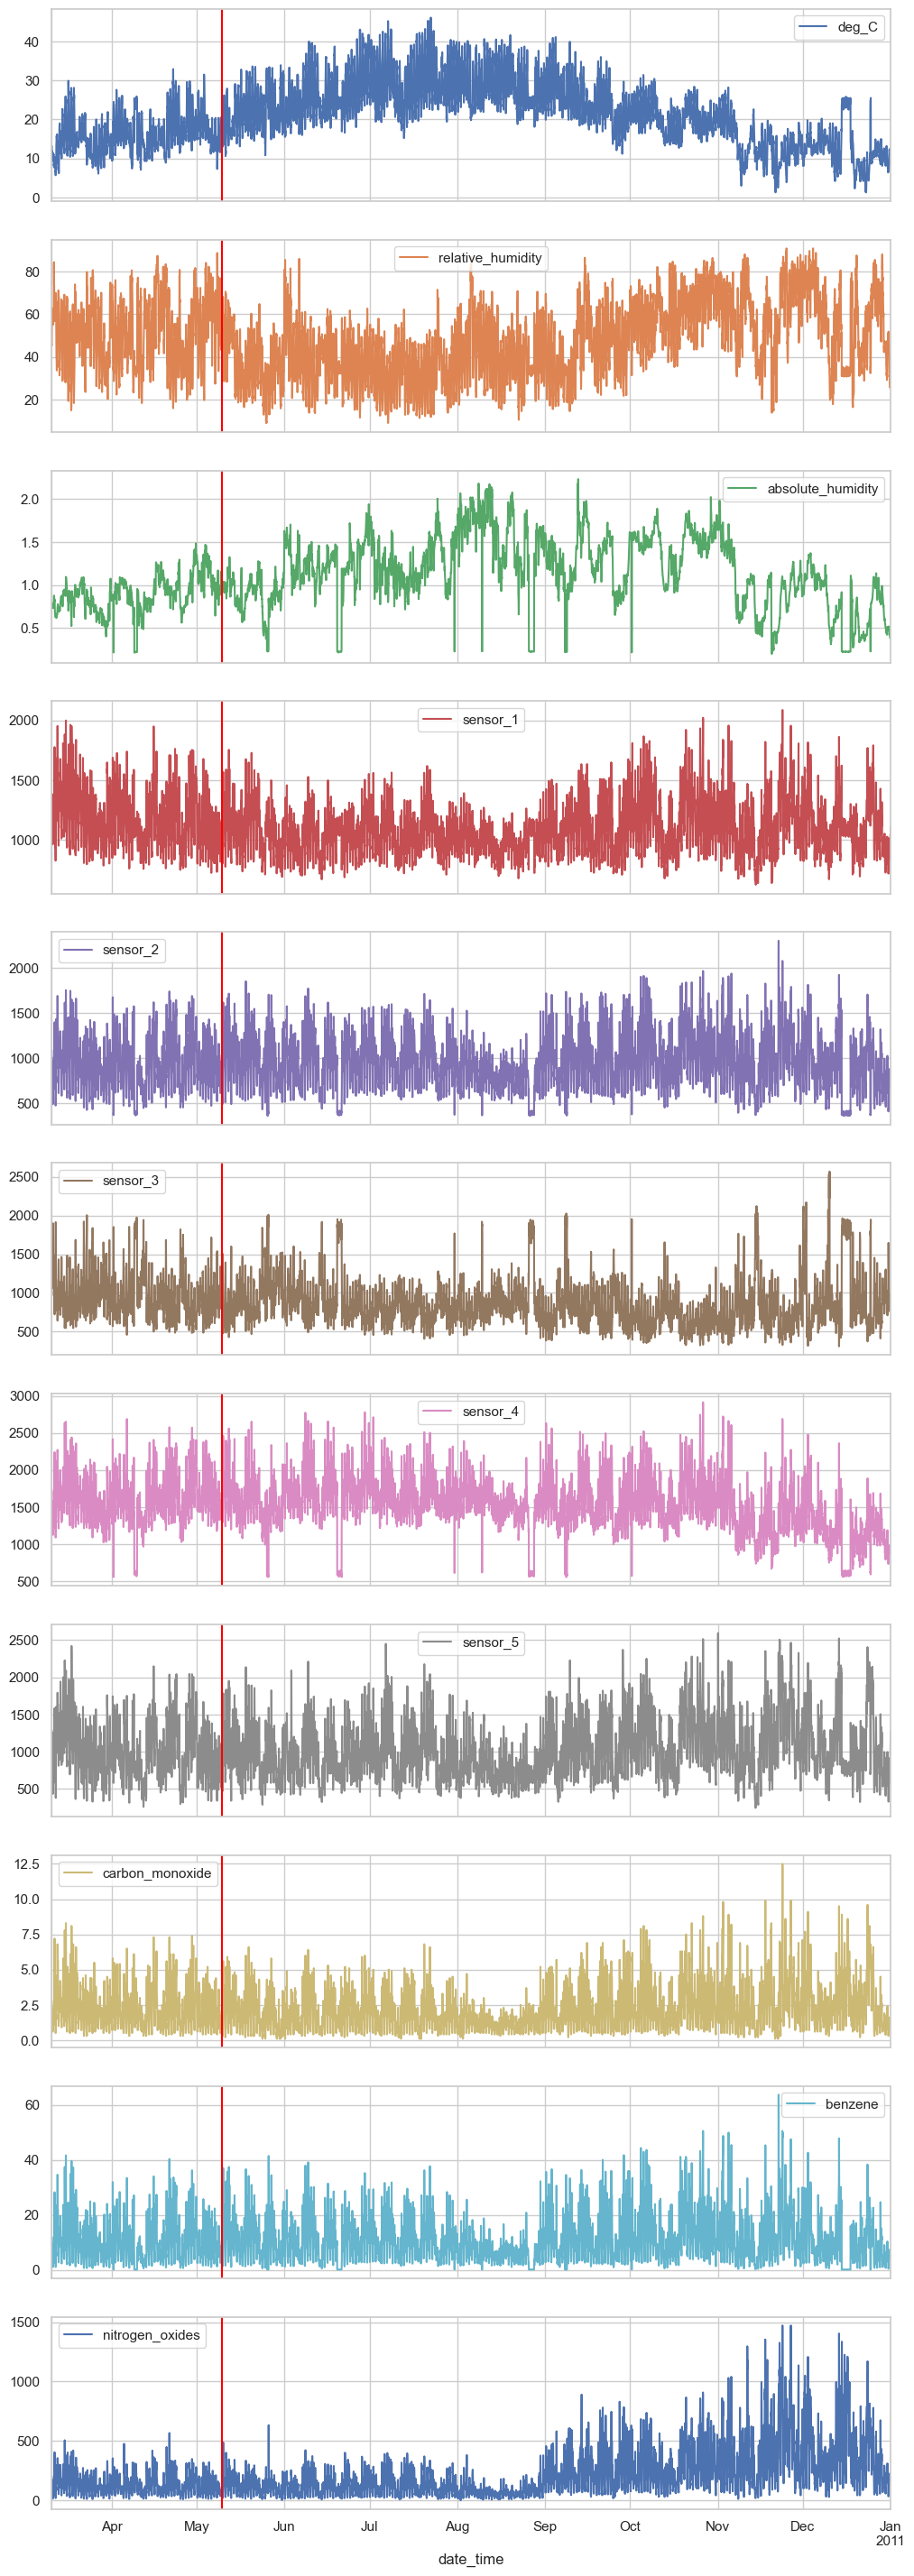

In [1]:
from lib.data.utils import train_data, targets, features

import seaborn as sns
sns.set_theme(context="notebook", style="whitegrid", rc={"figure.dpi": 100})

# Loading the dataset
data_path = "../data/"
df = train_data(data_path)

validation_length = (60*24)
validation_mark = df.index[validation_length]

# Displaying the dataset and marking the split between the validation and the training sections
axes = df[features + targets].plot(subplots=True, figsize=(12, 36))
for ax in axes:
    ax.axvline(validation_mark, color="red")


I grafici suggeriscono le seguenti considerazioni:
- sono presenti significative componenti periodiche nei segnali di input e output (tante proprietà fisico/chimiche dell'atmosfera sono legate ai cicli del sole e delle sorgenti naturali o antropiche delle sostanze coinvolte);
- ci sono almeno quattro brevi finestre di dati "sospetti" nella prima metà di aprile, nelle seconde metà di giugno e agosto e a metà dicembre;
- alcune features potrebbero essere anche significativamente correlate.

## Regressione lineare
Sono eseguiti di seguito due fit lineari del dataset (uno regolarizzato e uno no) utilizzando procedure fornite dalla libreria [scikit-learn](https://scikit-learn.org).
Il fit regolarizzato impiega l'algoritmo Lasso; il parametro di regolarizzazione ottimale viene cercato tramite 5-fold cross-validation sulla solita frazione del dataset di training.

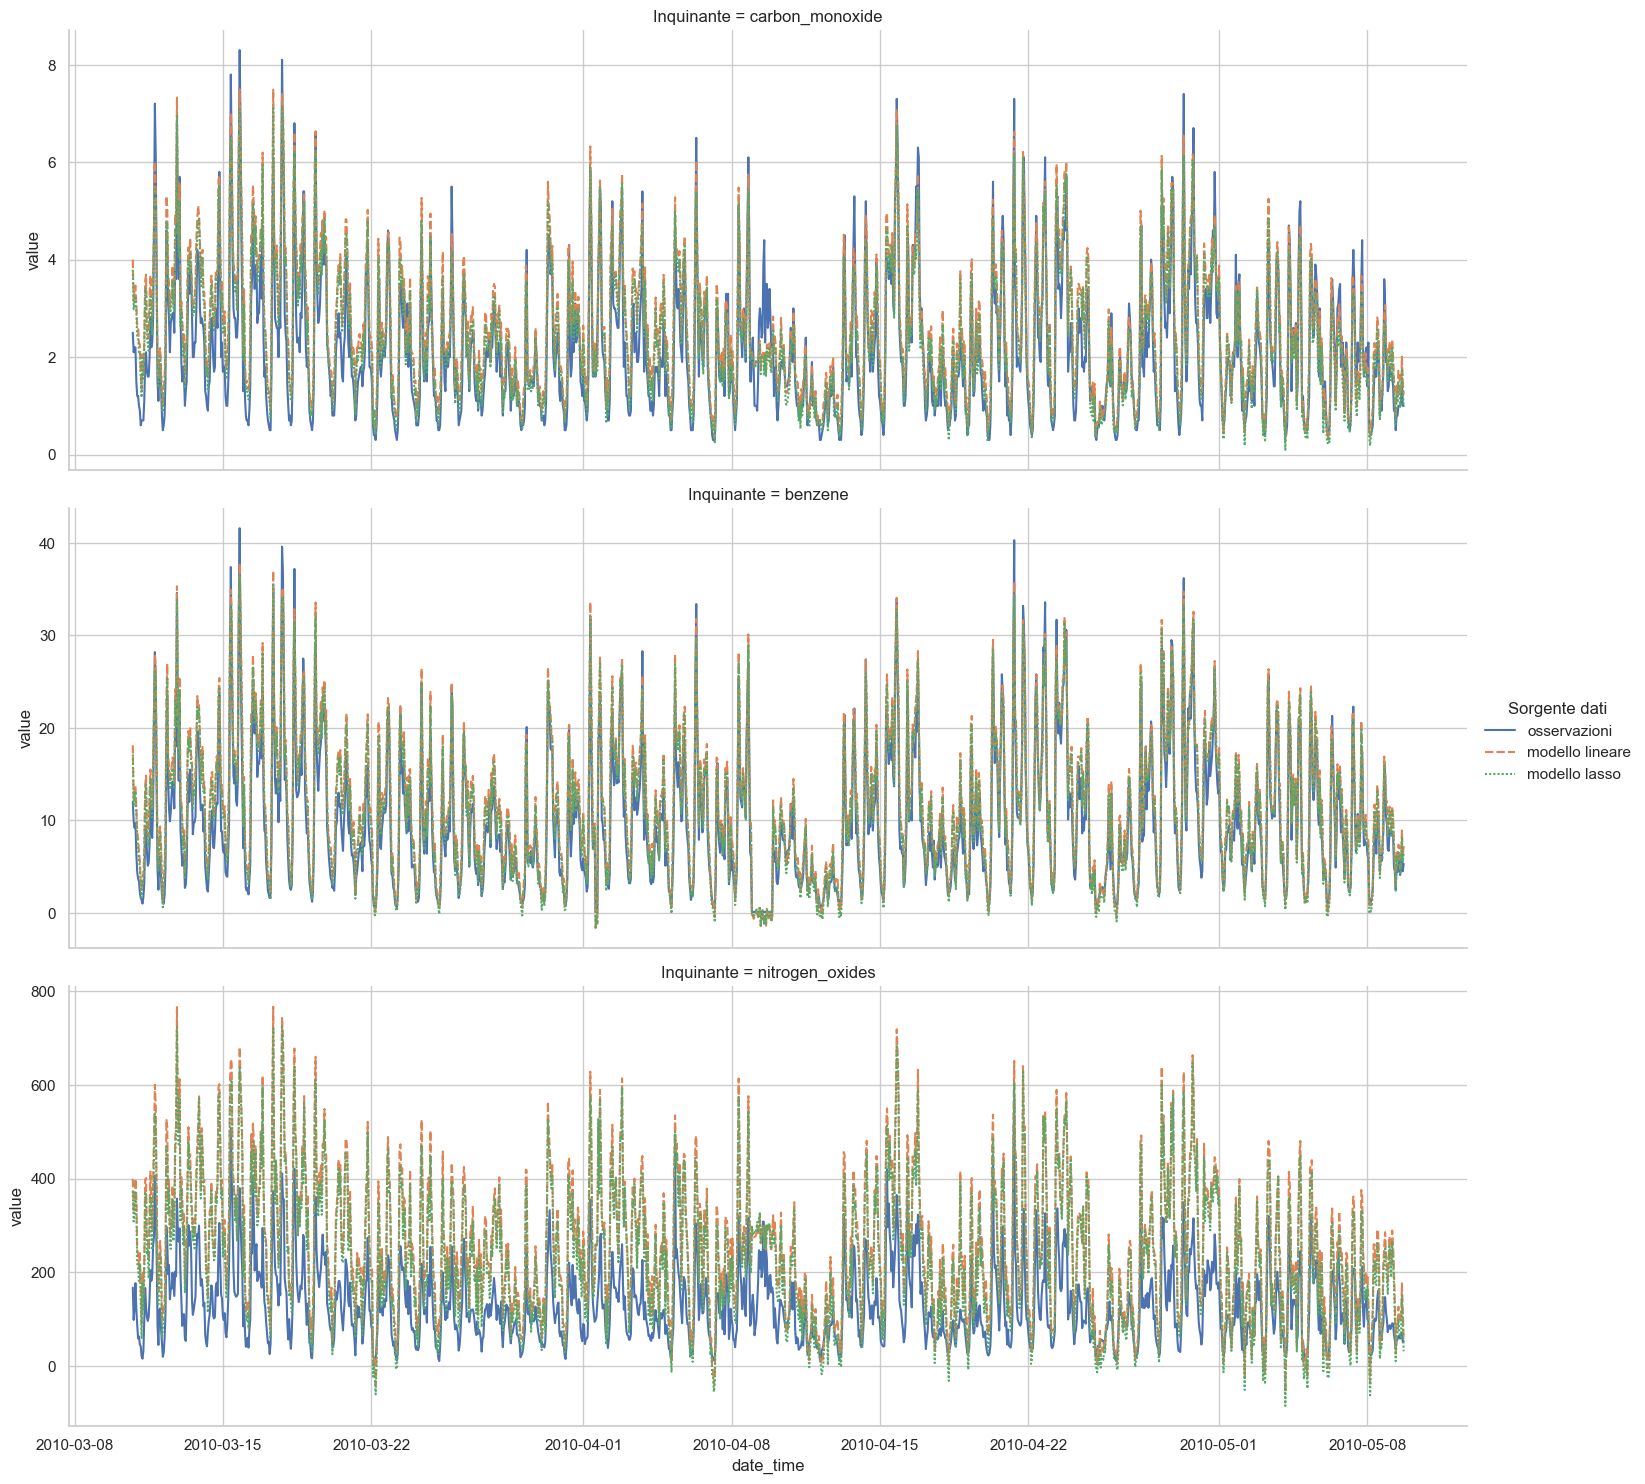

In [2]:
from lib.data.utils import split_dataframe

from sklearn.linear_model import LinearRegression, Lasso, MultiTaskLassoCV
import pandas as pd

# Splitting training and validation datasets using 60 days (*24h) as a validation size
(_, train_df), valid_df = split_dataframe(
    df, validation_length=(60*24), start=0)
X_train, y_train = train_df[features], train_df[targets]
X_valid, y_valid = valid_df[features], valid_df[targets]

# Fitting the linear models
# Raw linear model
linear_model = LinearRegression().fit(X_train, y_train)
# Lasso linear model, with 5-fold cross-validation based parameter search. Default arguments lead to an exploration of 100 values of the parameter spanning three orders of magnitude
lasso_model = MultiTaskLassoCV().fit(X_train, y_train)

# Producing and labeling predictions
y_pred = [pd.DataFrame.from_records(model.predict(
    X_valid), columns=targets, index=X_valid.index) for model in [linear_model, lasso_model]]

# Grouping results and observed values in a single dataframe suitable to be plotted by seaborn
valid_pred_df = (
    pd.concat([y_valid] + y_pred, keys=["osservazioni", "modello lineare", "modello lasso"],
              axis=1, names=["Sorgente dati", "Inquinante"])
    .melt(ignore_index=False)
)
# Plotting expected results vs predicted results
sns.relplot(data=valid_pred_df, x="date_time", y="value",
            row="Inquinante", hue="Sorgente dati", style="Sorgente dati", kind="line", aspect=3, facet_kws={"sharey": False})


Sotto vengono riportate le misure di errore quadratico medio sul dataset di validazione

In [3]:
from sklearn.metrics import mean_squared_error

# Showing the mean squared error for the two linear models
for name, prediction in zip(["lineare", "Lasso"], y_pred):
    print(f"MSE {name}: {mean_squared_error(y_valid.to_numpy(), prediction):.2f}")

MSE lineare: 7346.12
MSE Lasso: 5606.56


Lasso produce un errore significativamente inferiore, cosa che rinforza l'ipotesi che le features presentino un notevole grado di correlazione.

### Reti neurali ricorrenti (RNN)
In questa sezione verranno messi a confronto i risultati ottenuti con varie configurazioni di RNN, ottenute:
1. modificando il numero di parametri (basso, intermedio, alto);
2. allenando la rete su target normalizzati o meno.

L'architettura impiegata è molto semplice, e consta di un modello sequenziale che concatena un layer LSTM (il cui numero di output sarà variato per aumentare o ridurre la complessità del modello) seguito da un layer denso con 3 neuroni, uno per output. I dati in input vengono normalizzati rispetto a media e varianza del dataset di training, così come gli output vengono "denormalizzati" sempre rispetto a media e varianza dei target del training. Il modello riceve in input sequenze orarie da 5 giorni di misure delle 8 features e restituisce le stime puntuali e contemporanee di concentrazione degli inquinanti (si intende questo quando si fa riferimento nel codice ad una rete "on the fly").
Si è scelto di utilizzare layers di tipo LSTM perchè è un algoritmo notoriamente più robusto rispetto all'RNN "vanilla".

Vengono nuovamente applicate delle forme di regolarizzazione tipo Lasso sui pesi dei kernel sia del layer RNN che del layer fully-connected, si è visto che anche qui migliorano il risultato.

I valori scelti per gli iperparametri (learning rate e coefficiente del Lasso) sono stati selezionati tramite grid search.

In [4]:
# Suppressing tensorflow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from lib.data.plot import plot_predictions
# A python object for the nn
from lib.models.on_the_fly import OnTheFlyLSTM
# A python object for the estimator, which provides high level routines and normalization facilities
from lib.models.estimators import PollutionEstimator
from keras.callbacks import EarlyStopping as ES
from keras.optimizers import Adam
from keras.regularizers import l1

(_, train_df), valid_df = split_dataframe(
    df, validation_length=(60*24), start=0)

# Defining a regularization parameter for the RNN kernel weights. The parameter value was found through a quick trial and error search.
L = l1(0.1)
n_recursive_units = [3, 64, 256]
#  Allocating the pollution model, which is the RNN. It accepts len(features) inputs structured in windows of 5 days worth of hourly measurements and provides len(targets) outputs.
# The RNN itself uses 64 recursive units.
models = [OnTheFlyLSTM(len(features), len(targets), n_recursive_units=n_u, input_days=5, dense_kwargs={"kernel_regularizer": "l1"}, rnn_kwargs={
                       "kernel_regularizer": L, "recurrent_regularizer": "l1"}) for n_u in n_recursive_units]
# Allocating the estimator
estimators = [PollutionEstimator(features, targets, model) for model in models]
# Adapting the normalization layers (both in input and output) to the training data
for estimator in estimators:
    estimator.adapt_training(train_df)
    estimator.compile(loss="mae", optimizer=Adam(
        learning_rate=5e-4), metrics=["mse"])
    # Calling early stopping on the training procedure to avoid overfitting and cut on computation time. Data is split by the training procedure into overlapping windows of consecutive measurements, with a window shift of 1 (hour).
    estimator.train(train_df, epochs=300, shift_hours=1, validation_data=valid_df,
                    # This batch size works well on my machine while making use of the GPU
                    batch_size=128, callbacks=[ES(patience=20, restore_best_weights=True)])


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/300
44/44 [==============================] - 4s 40ms/step - loss: 58.1966 - mse: 16169.3613 - val_loss: 50.2012 - val_mse: 8404.8350
Epoch 2/300
44/44 [==============================] - 1s 25ms/step - loss: 54.2210 - mse: 14959.8662 - val_loss: 48.3627 - val_mse: 7792.4668
Epoch 3/300
44/44 [==============================] - 1s 25ms/step - loss: 51.1728 - mse: 14197.0693 - val_loss: 46.7804 - val_mse: 7263.4800
Epoch 4/300
44/44 [==============================] - 1s 25ms/step - loss: 48.6741 - mse: 13553.5049 - val_loss: 45.7947 - val_mse: 6917.5015
Epoch 5/300
44/44 [==============================] - 1s 25ms/step - loss: 46.5119 - mse: 12964.5830 - val_loss: 45.3646 - val_mse: 6736.5269
Epoch 6/300
44/44 [==============================] - 1s 24ms/step - loss: 44.6617 - mse: 12381.5146 - val_loss: 45.5911 - val_mse: 6761.1709
Epoch 7/300
44/44 [==============================] - 1s 25ms/step - loss: 43.

1/1 [==============================] - 0s 264ms/step


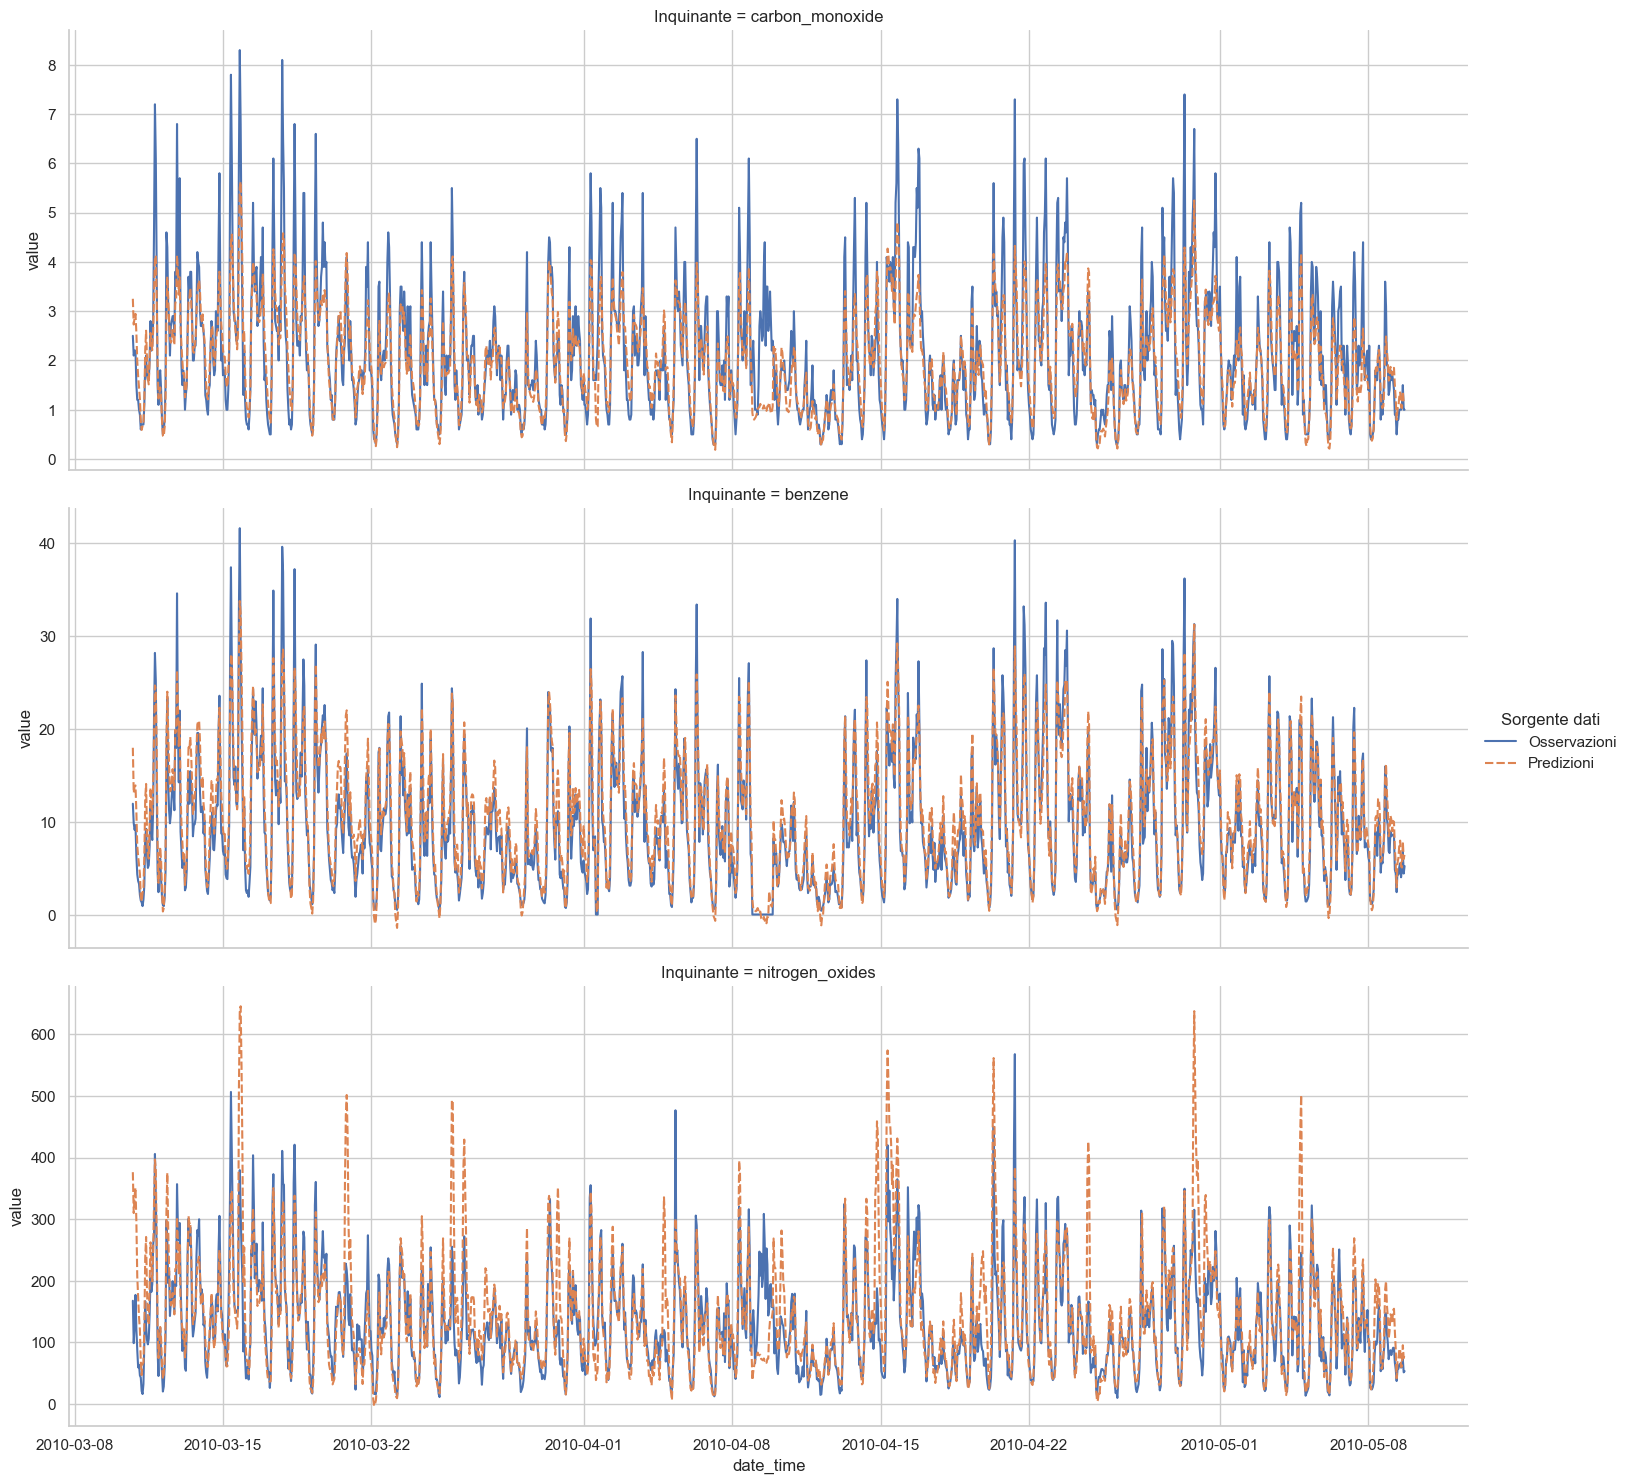

In [5]:
# Plotting an example of predictions
plot_predictions(valid_df, estimators[2], aspect=3, facet_kws={"sharey": False})

Il grafico sembra mostrare una maggiore accordanza tra osservazioni e previsioni, almeno per la serie degli $\mathrm{NO_X}$.

Di seguito si controlla se questa ipotesi è confermata dal MSE.

In [6]:
for n_u, estimator in zip(n_recursive_units, estimators):
    prediction = estimator.forecast(valid_df, batch_size=128, verbose=0)
    print(f"MSE della rete con {n_u} output ricorrenti:", mean_squared_error(y_valid.to_numpy(), prediction))
    

MSE della rete con 3 output ricorrenti: 6736.526702464518
MSE della rete con 64 output ricorrenti: 1128.231076538589
MSE della rete con 256 output ricorrenti: 1081.7400294783868


MSE conferma una riduzione dell'errore di un fattore da 5 a 10 (in genere) rispetto ai modelli lineari. La complessità del modello non sembra influire molto, a queste scale, sulle performance, per quanto il risultato sia molto volatile.

Si esegue infine un fit sul dataset con target normalizzati.

In [7]:
(_, train_df), valid_df = split_dataframe(
    df, validation_length=(60*24), start=0)
mean, std = train_df[targets].mean(), train_df[targets].std()
train_df.loc[:, targets] = (train_df[targets] - mean) / std
valid_df.loc[:, targets] = (valid_df[targets] - mean) / std

n_recursive_units = [3, 64, 256]
models = [OnTheFlyLSTM(len(features), len(targets), n_recursive_units=n_u, input_days=5, dense_kwargs={"kernel_regularizer": "l1"}, rnn_kwargs={
                       "kernel_regularizer": L, "recurrent_regularizer": "l1"}) for n_u in n_recursive_units]
# Allocating the estimator
estimators = [PollutionEstimator(features, targets, model) for model in models]
# Adapting the normalization layers (both in input and output) to the training data
for estimator in estimators:
    estimator.adapt_training(train_df)
    estimator.compile(loss="mae", optimizer=Adam(
        learning_rate=5e-4), metrics=["mse"])
    # Calling early stopping on the training procedure to avoid overfitting and cut on computation time. Data is split by the training procedure into overlapping windows of consecutive measurements, with a window shift of 1 (hour).
    estimator.train(train_df, epochs=300, shift_hours=1, validation_data=valid_df,
                    # This batch size works well on my machine while making use of the GPU
                    batch_size=128, callbacks=[ES(patience=10, restore_best_weights=True)])


Epoch 1/300
44/44 [==============================] - 3s 38ms/step - loss: 3.5370 - mse: 1.1887 - val_loss: 3.3494 - val_mse: 0.9154
Epoch 2/300
44/44 [==============================] - 1s 25ms/step - loss: 3.3079 - mse: 1.1605 - val_loss: 3.1206 - val_mse: 0.8800
Epoch 3/300
44/44 [==============================] - 1s 25ms/step - loss: 3.0854 - mse: 1.1361 - val_loss: 2.8976 - val_mse: 0.8476
Epoch 4/300
44/44 [==============================] - 1s 25ms/step - loss: 2.8715 - mse: 1.1161 - val_loss: 2.6819 - val_mse: 0.8177
Epoch 5/300
44/44 [==============================] - 1s 25ms/step - loss: 2.6654 - mse: 1.0987 - val_loss: 2.4738 - val_mse: 0.7910
Epoch 6/300
44/44 [==============================] - 1s 25ms/step - loss: 2.4676 - mse: 1.0833 - val_loss: 2.2761 - val_mse: 0.7650
Epoch 7/300
44/44 [==============================] - 1s 25ms/step - loss: 2.2813 - mse: 1.0699 - val_loss: 2.0913 - val_mse: 0.7404
Epoch 8/300
44/44 [==============================] - 1s 25ms/step - loss: 2.

1/1 [==============================] - 0s 316ms/step


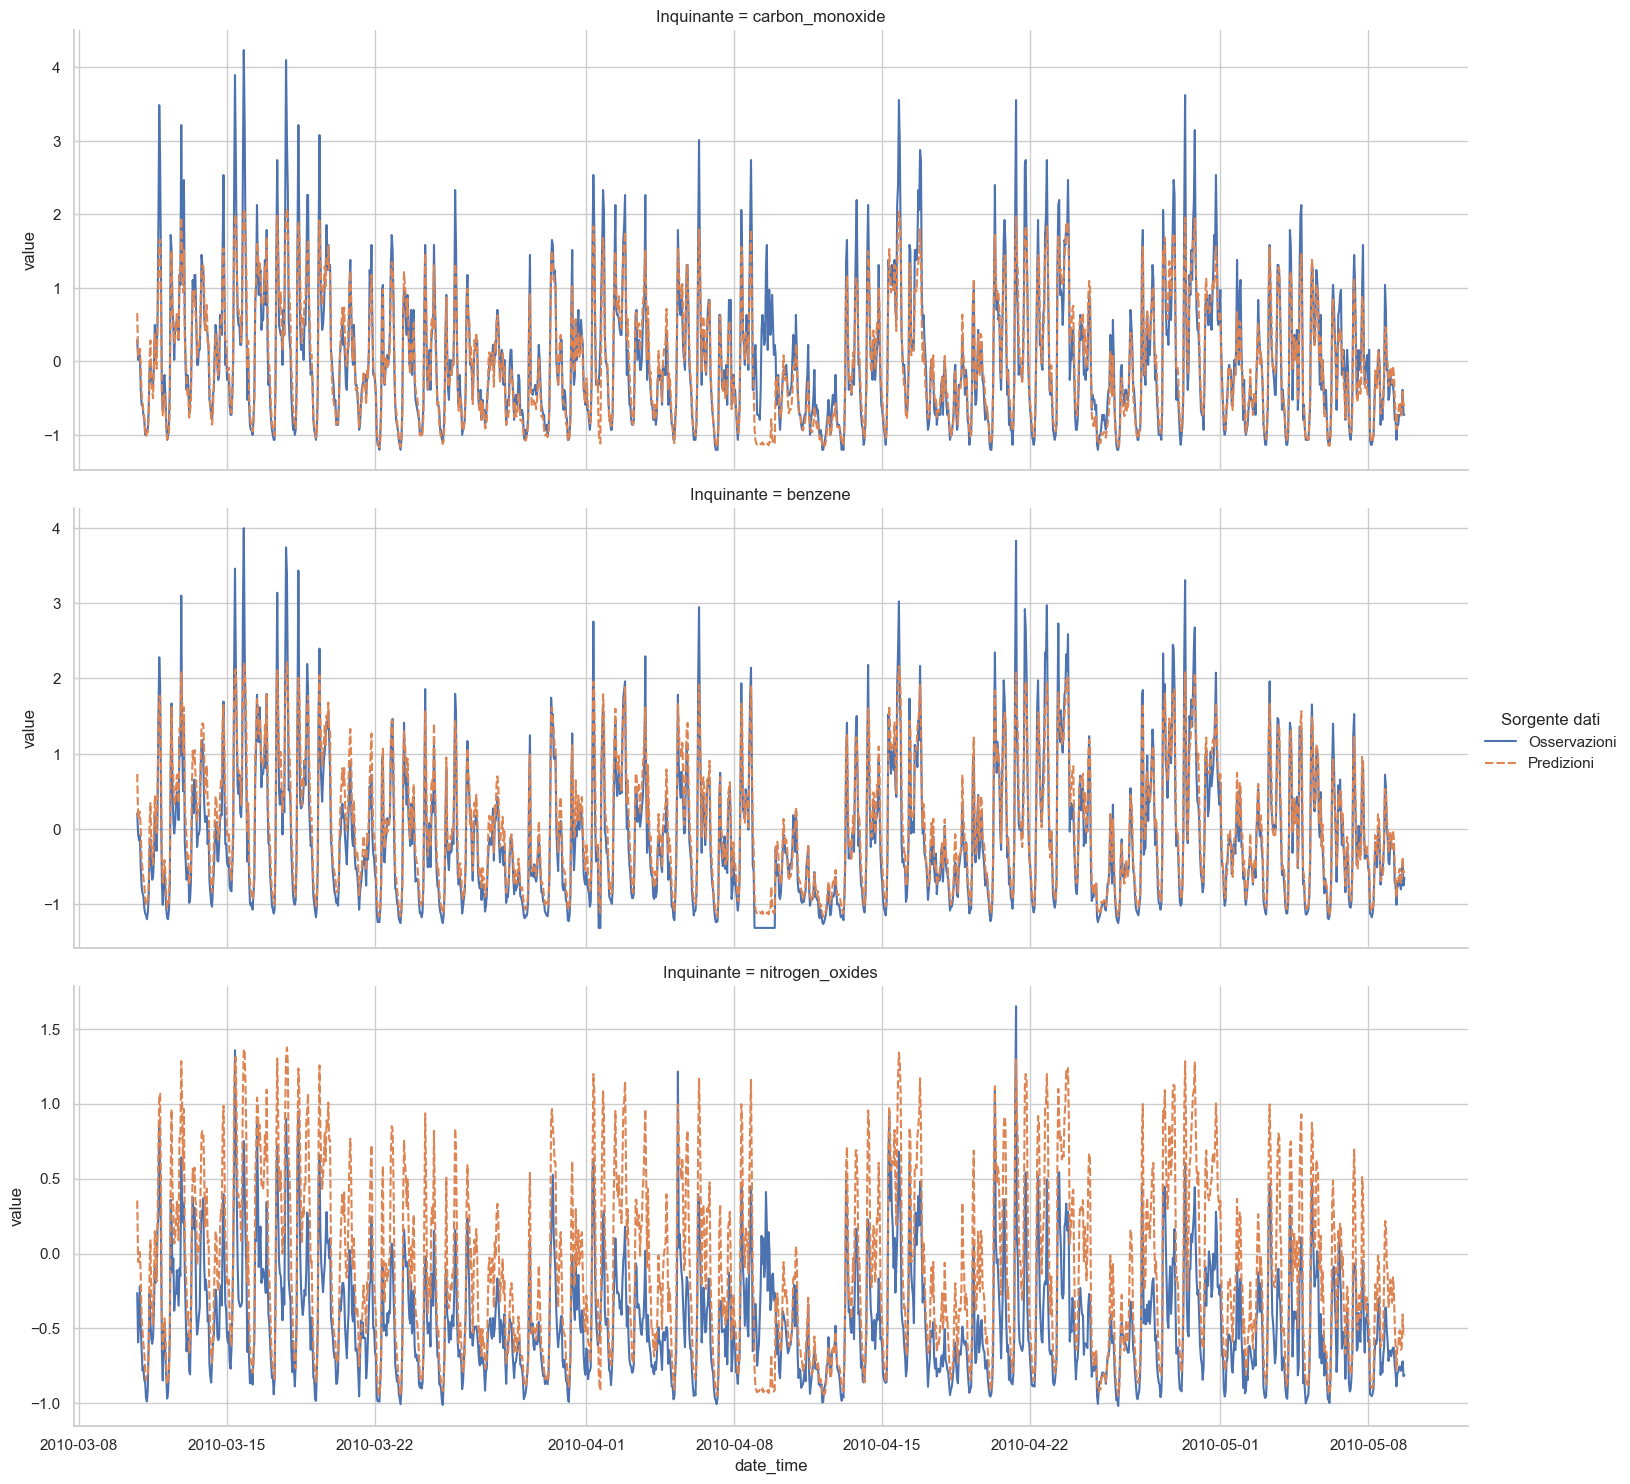

In [8]:
plot_predictions(valid_df, estimators[0], aspect=3, facet_kws={"sharey": False})

In [9]:
for n_u, estimator in zip(n_recursive_units, estimators):
    prediction = estimator.forecast(valid_df, batch_size=128, verbose=0) * std + mean
    print(f"MSE della rete con {n_u} output ricorrenti:", mean_squared_error(y_valid.to_numpy(), prediction))

MSE della rete con 3 output ricorrenti: 2814.0369514203812
MSE della rete con 64 output ricorrenti: 1976.0855866239554
MSE della rete con 256 output ricorrenti: 2372.4420675797383


L'approccio tentato sopra sembra restituire risultati peggiori, anche se, nuovamente, cambiare l'inizializzazione dei pesi può portare a risultati anche molto differenti.